In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import random
from sklearn.metrics import confusion_matrix, mean_squared_error, log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
from tensorflow.keras.models import model_from_json
from tensorflow.keras import layers, Model
from tensorflow.keras import optimizers

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)

In [12]:
experi = pd.read_csv('results_clip_cluster_0/NN_experiments_with_1.0data.csv')

In [13]:
experi

,best_dev_mse,history,hyperparam
0,0.03609,"{'loss': [0.03920776502457632, 0.037692687256800375, 0.037328493495628376, 0.03710551380247367, ...","{'opt': 'adam', 'fc_hidden_size': 128, 'lr': 0.005793115158586209, 'n_fc_layers': 4}"


In [14]:
experi = experi.sort_values('best_dev_mse', axis=0)

## load the best model to analyze

In [15]:
# best = experiments.loc[experiments['best_dev_mse'] == min(experiments['best_dev_mse'])]
best = experi.iloc[:1,:]
best

,best_dev_mse,history,hyperparam
0,0.03609,"{'loss': [0.03920776502457632, 0.037692687256800375, 0.037328493495628376, 0.03710551380247367, ...","{'opt': 'adam', 'fc_hidden_size': 128, 'lr': 0.005793115158586209, 'n_fc_layers': 4}"


In [16]:
hyp_str = best['hyperparam'].to_list()[0]
hyp = hyp_str.replace("'", "\"")
hyp_params = json.loads(hyp)
hyp_params

{'fc_hidden_size': 128,
 'lr': 0.005793115158586209,
 'n_fc_layers': 4,
 'opt': 'adam'}

In [17]:
h_str = best['history'].to_list()[0]
history = h_str.replace("'", "\"")
hist = json.loads(history)

hist_df = pd.DataFrame(data=hist)
hist_df['epoch'] = range(0, len(hist_df))

best_detail = hist_df.loc[hist_df['val_loss'] == min(hist_df['val_loss'])]
best_detail

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
16,0.036235,0.036235,0.03609,0.03609,16


In [18]:
Xtrain = np.load('encoded_data_clip_fast/Xtrain.npy')
Xdev = np.load('encoded_data_clip_fast/Xdev.npy')
Xtest = np.load('encoded_data_clip_fast/Xtest.npy')

ytrain = np.load('encoded_data_clip_fast/ytrain.npy')
ydev = np.load('encoded_data_clip_fast/ydev.npy')
ytest = np.load('encoded_data_clip_fast/ytest.npy')

In [474]:
model_n = 0
# load json and create model
model_path = 'results_clip_cluster_linearTransformation/NNmodel_{}_with_1.0data.json'.format(model_n)
print(model_path)
weights_path = 'results_clip_cluster_linearTransformation/NNmodel_{}_with_1.0data_weights.hdf5'.format(model_n)

json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
if hyp_params['opt'] == 'adam':
    opt = optimizers.Adam(lr=hyp_params['lr'])
elif hyp_params['opt'] == 'rmsprop':
    opt = optimizers.RMSprop(lr=hyp_params['lr'])
elif hyp_params['opt'] == 'sgd':
    opt = optimizers.SGD(lr=hyp_params['lr'])
else:
    raise ValueError('Unknown optimizer: {}'.format(hyp_params['opt']))

loaded_model.compile(loss='mean_squared_error', optimizer=opt,
                     metrics=['mean_squared_error'])

results_clip_cluster_linearTransformation/NNmodel_0_with_1.0data.json
Loaded model from disk


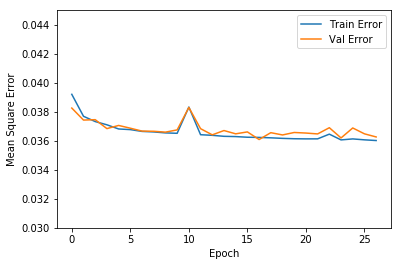

In [475]:
def plot_history(hist_df):
    

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist_df['epoch'], hist_df['mean_squared_error'],
           label='Train Error')
    plt.plot(hist_df['epoch'], hist_df['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0.03,0.045])
    plt.legend()
    plt.savefig('plots/bestNNmodel_learning_curve.png')
    plt.show()


plot_history(hist_df)



In [476]:
train_pred = loaded_model.predict(Xtrain)
train_mse = mean_squared_error(ytrain, train_pred)
train_mse

0.03580122415673818

In [477]:
dev_pred = loaded_model.predict(Xdev)
dev_mse = mean_squared_error(ydev, dev_pred)
dev_mse

0.036090237673891

In [23]:
test_pred = loaded_model.predict(Xtest)
test_mse = mean_squared_error(ytest, test_pred)
test_mse

0.03570946654132299

In [24]:
np.sqrt(test_mse)

0.18896948574127778

## How is the performance on purchased workloads?

In [25]:
features = pd.read_csv('encoded_data_clip_fast/encoded_columns_name.txt', delimiter='\t', header=None)

In [26]:
outputs_name = [
     'AR_exchange_06',
 'AR_sharepoint_06',
 'AR_skype_06',
 'AR_teams_06',
 'AR_od4b_06',
 'AR_onenote_06',
 'AR_word_06',
 'AR_excel_06',
 'AR_powerpoint_06',
 'AR_outlook_06',
 'AR_eslt_06',
 'AR_officeclient_06'
]

In [27]:
features.columns = ['cols_name']

In [28]:
len(features)

446

In [29]:
features[:80]

,cols_name
0,AllupSeats
1,EXOSubscriptionsCount
2,OD4BSubscriptionsCount
3,SfBSubscriptionsCount
4,TeamsSubscriptionsCount
5,PaidCount
6,ProjectSubscriptionsCount
7,SPOSubscriptionsCount
8,ActivatedSubscriptionTotalCount
9,VisioSubscriptionsCount


In [30]:
total_index = features.loc[features['cols_name'] == 'PaidCount'].index
exo_index = features.loc[features['cols_name'] == 'PaidEXOSeats'].index
spo_index = features.loc[features['cols_name'] == 'PaidSPOSeats'].index
od4b_index = features.loc[features['cols_name'] == 'PaidOD4BSeats'].index
teams_index = features.loc[features['cols_name'] == 'PaidTeamsSeats'].index
sfb_index = features.loc[features['cols_name'] == 'PaidSFBSeats'].index
office_index = features.loc[features['cols_name'] == 'PaidOfficeSeats'].index

In [31]:
Xdev[:,exo_index].shape


(13863, 1)

In [32]:
# outputs_name

In [33]:
mask_exo = np.where(Xdev[:,exo_index] > 0, 1, 0)
# mask_exo = mask_exo.reshape(Xdev.shape[0], 1)
mask_exo.shape

(13863, 1)

In [34]:
mask_spo = np.where(Xdev[:,spo_index] > 0, 1, 0)
mask_sfb = np.where(Xdev[:,sfb_index] > 0, 1, 0)
mask_teams = np.where(Xdev[:,teams_index] > 0, 1, 0)
mask_od4b = np.where(Xdev[:,od4b_index] > 0, 1, 0)
mask_eslt = np.where(Xdev[:,total_index] > 0, 1, 0)
mask_office = np.where(Xdev[:,office_index] > 0, 1, 0)

In [35]:
mask_office_all = np.ones((Xdev.shape[0], 5))

for i in range(5):
    mask_office_all[:,i] = mask_office[:,0]
    

In [36]:
mask_office_all.sum() == mask_office.sum() * 5

True

In [37]:
mask = np.concatenate([mask_exo, mask_spo, mask_sfb, mask_teams, mask_od4b, 
                       mask_office_all, mask_eslt, mask_office], axis=1)

In [38]:
mask.shape

(13863, 12)

In [39]:
squared_error = np.square(dev_pred - ydev)

In [464]:
purchased_workload_mse_multi = np.sum(mask * squared_error, axis=0) / np.sum(mask, axis=0)

In [465]:
purchased_workload_mse_multi

array([0.05772604, 0.03418422, 0.00619309, 0.02573088, 0.01617348,
       0.00285617, 0.08358876, 0.09965892, 0.05925853, 0.08271129,
       0.04592504, 0.06785257])

In [466]:
purchased_workload_ = {}

for i, n in enumerate(outputs_name):
    
    purchased_workload_[n] = purchased_workload_mse_multi[i]
    
s = pd.Series(purchased_workload_).sort_values()

print(s)

AR_onenote_06         0.002856
AR_skype_06           0.006193
AR_od4b_06            0.016173
AR_teams_06           0.025731
AR_sharepoint_06      0.034184
AR_eslt_06            0.045925
AR_exchange_06        0.057726
AR_powerpoint_06      0.059259
AR_officeclient_06    0.067853
AR_outlook_06         0.082711
AR_word_06            0.083589
AR_excel_06           0.099659
dtype: float64


In [467]:
purchased_workload_mse = np.mean(purchased_workload_mse_multi)
purchased_workload_mse

0.04848824828846881

In [468]:
purchased_workload_std_multi = np.std((dev_pred - ydev), axis=0)
purchased_workload_std_multi

array([0.26584402, 0.15481887, 0.05225176, 0.11568336, 0.17855501,
       0.05635216, 0.17599691, 0.18627769, 0.08621546, 0.27634781,
       0.25564858, 0.26745248])

In [469]:
purchased_workload_rmse_multi = np.sqrt(purchased_workload_mse_multi)
purchased_workload_rmse_multi

array([0.24026245, 0.18488975, 0.07869616, 0.16040847, 0.12717498,
       0.05344316, 0.28911721, 0.31568801, 0.24343075, 0.28759571,
       0.21430127, 0.26048525])

In [470]:
rmse_std_multi = (purchased_workload_rmse_multi / purchased_workload_std_multi).reshape((12,1))
purchased_workload_std_multi = purchased_workload_std_multi.reshape((12,1))

purchased_workload_rmse_multi = purchased_workload_rmse_multi.reshape((12,1))
purchased_workload_mse_multi = purchased_workload_mse_multi.reshape((12,1))

rmse_data = np.concatenate((purchased_workload_mse_multi, purchased_workload_rmse_multi,
                            purchased_workload_std_multi, rmse_std_multi), axis=1)

In [471]:
purchased_wl_rmse_multi_df = pd.DataFrame(data=rmse_data, columns=['mse', 'rmse', 'std', 'rmse/std'],
                                          index=outputs_name)
purchased_wl_rmse_multi_df

,mse,rmse,std,rmse/std
AR_exchange_06,0.057726,0.240262,0.265844,0.903772
AR_sharepoint_06,0.034184,0.184890,0.154819,1.194233
AR_skype_06,0.006193,0.078696,0.052252,1.506096
AR_teams_06,0.025731,0.160408,0.115683,1.386617
AR_od4b_06,0.016173,0.127175,0.178555,0.712245
AR_onenote_06,0.002856,0.053443,0.056352,0.948378
AR_word_06,0.083589,0.289117,0.175997,1.642740
AR_excel_06,0.099659,0.315688,0.186278,1.694717
AR_powerpoint_06,0.059259,0.243431,0.086215,2.823516
AR_outlook_06,0.082711,0.287596,0.276348,1.040702


## Clustering the mature tenants

In [48]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  [(None, 446)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               57216     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                36    

In [49]:
output_weights = loaded_model.get_weights()[-2]
output_weights.shape

(2, 12)

In [50]:
output_bias = loaded_model.get_weights()[-1]
output_bias.shape

(12,)

In [53]:
model = loaded_model
last2nd_layer_index = hyp_params['n_fc_layers']+1
last2nd_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(index=last2nd_layer_index).output)

last2nd_layer_output = last2nd_layer_model.predict(Xdev)

last2nd_layer_output.shape

(13863, 2)

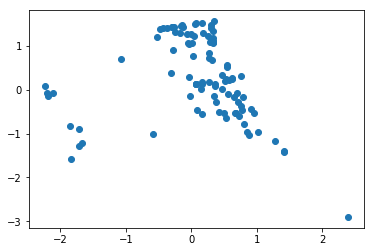

In [54]:
plt.figure()
plt.scatter(x=last2nd_layer_output[:100,0], y=last2nd_layer_output[:100,1])

In [55]:
def plot_decision_heatmap(f, x, y, name, size=100, save_fn=None, data=None, ids=None):
    sz = size
    x_min, x_max, y_min, y_max = -3, 3, -4, 2
    X,Y = np.meshgrid(np.linspace(x_min,x_max,sz),np.linspace(y_min,y_max,sz))
    grid_inputs = np.vstack([np.reshape(X, -1), np.reshape(Y, -1)]).T

    output = f(grid_inputs)
    G = np.reshape(output, [size, size])
    fig,ax = plt.subplots()
    plt.contourf(X, Y, G, cmap=plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(x, y, 0.1)
    plt.title(name)

#     if data is not None and ids is not None:
#         d = data
#         ids = ids
#         plt.scatter(d[:,0][ids==0], d[:,1][ids==0], marker='x', c='blue')
#         plt.scatter(d[:,0][ids==1], d[:,1][ids==1], marker='x', c='r')

#         plt.scatter(few_data[:,0][few_ids==0], few_data[:,1][few_ids==0], marker='x', c='black')
#         plt.scatter(few_data[:,0][few_ids==1], few_data[:,1][few_ids==1], marker='x', c='black')

#     if save_fn:
#         plt.savefig(save_fn)

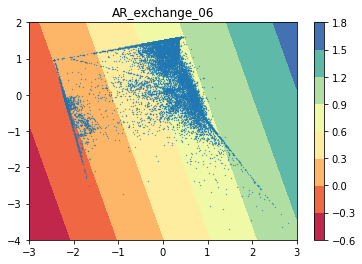

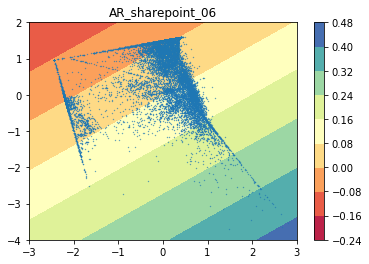

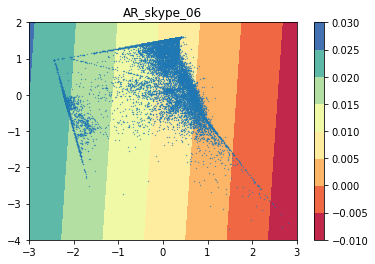

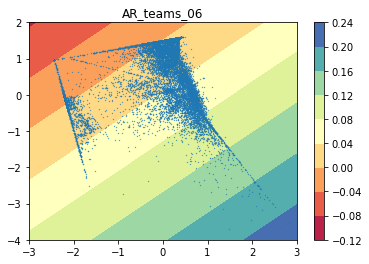

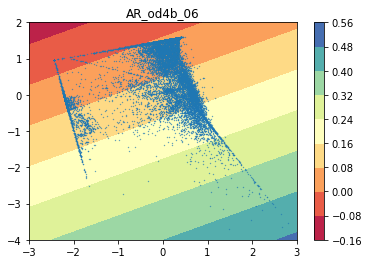

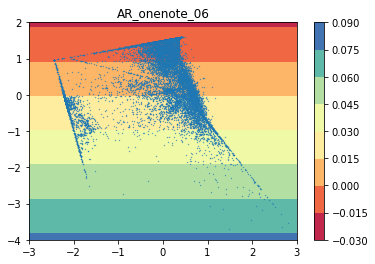

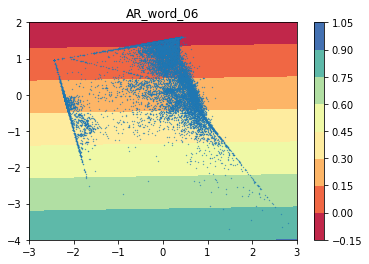

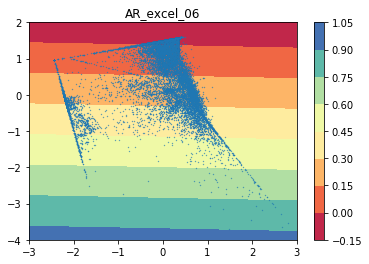

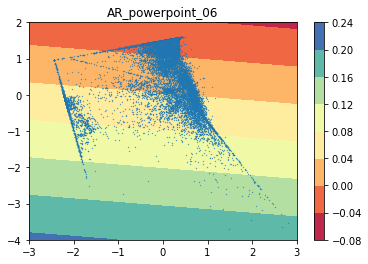

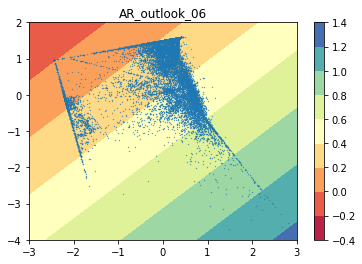

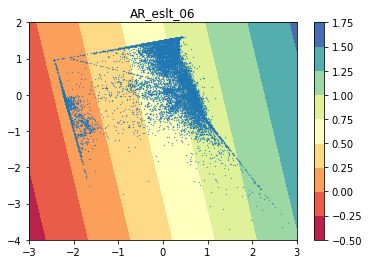

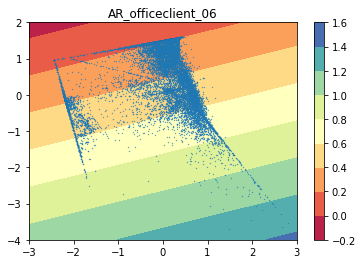

In [56]:
for i_workload in range(12):
    w = output_weights[:,i_workload]
    b = output_bias[i_workload]
    def f(x):
        return x.dot(w) + b
    plot_decision_heatmap(f, last2nd_layer_output[:,0], last2nd_layer_output[:,1], outputs_name[i_workload])

In [ ]:
df_dev = pd.read_csv('encoded_data_clip_fast/dev_set_raw_data.csv')
scaler = joblib.load('encoded_data_clip_fast/scaler.pkl')

In [436]:
from sklearn import cluster, mixture
from itertools import cycle, islice

n_examples = Xdev.shape[0]
X = last2nd_layer_output[:n_examples]
K = 4
np.random.seed(314)
algo = cluster.MiniBatchKMeans(n_clusters=K)
# algo = cluster.SpectralClustering(
#     n_clusters=K, eigen_solver='arpack',
#     affinity="nearest_neighbors")

algo = mixture.GaussianMixture(
    n_components=K, covariance_type='full')

%time algo.fit(X)
if hasattr(algo, 'labels_'):
    y_pred = algo.labels_.astype(np.int)
else:
    y_pred = algo.predict(X)


CPU times: user 157 ms, sys: 991 µs, total: 158 ms
Wall time: 165 ms


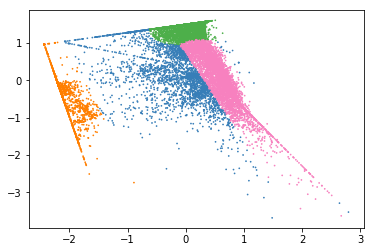

In [437]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=0.5, color=colors[y_pred])

In [410]:
# df_dev[:n_examples][y_pred == 0]


In [290]:
df_dev.head()
features = pd.read_csv('encoded_data_clip_fast/encoded_columns_name.txt', delimiter='\t', header=None)
features.columns = ['feature_name']
feature_name_dict = features.to_dict()['feature_name']
rev_feature_name_dict = dict([(v, k) for k, v in feature_name_dict.items()])

In [298]:
important_feature_names = ['PaidCount',
 'EXOEnabledUsers',
 'PPDEnabledUsers',
 'PaidEXOSeats',
 'CountryCode=US',
 'PaidProplusSeats',
 'Languange=en',
 'PaidOD4BSeats',
 'SfBSubscriptionsCount',
 'TotalUsers',
 'AllupSeats',
 'EXOSubscriptionsCount',
 'TeamEnabledUsers',
 'CountryCode=GB',
 'HasEXO',
 'PaidKaizalaSeats',
 'FirstPaidEXOStartDate',
 'FirstPaidOD4BStartDate',
 'TopParents_Industry=0',
 'CountryCode=DE',
 'O365EnabledUsers',
 'FirstPaidProPlusStartDate',
 'CountryCode=NL',
 'OD4BEnabledUsers',
 'TeamsSubscriptionsCount',
 'NonTrialSubscriptionsCount',
 'PaidSPOSeats',
 'ActivatedSubscriptionTotalCount',
 'OD4BSubscriptionsCount',
 'SPOEnabledUsers',
 'CountryCode=AU',
 'PaidSFBSeats',
 'Languange=de',
 'HasSPO',
 'CountryCode=CA',
 'Languange=es',
 'HasOD4B',
 'M365EnabledUsers',
 'YammerEnabledUsers',
 'CountryCode=FR']

industry_feature_names = ['TopParents_Industry=0',
 'TopParents_Industry=Partner Professional Services',
 'TopParents_Industry=Smart Spaces',
 'TopParents_Industry=Consumer Goods',
 'TopParents_Industry=Professional Services',
 'TopParents_Industry=Health Provider',
 'TopParents_Industry=Retailers',
 'TopParents_Industry=Nonprofit',
 'TopParents_Industry=Other - Unsegmented',
 'TopParents_Industry=Discrete Manufacturing',
 'TopParents_Industry=Media & Entertainment',
 'TopParents_Industry=Chemicals & Agrochemicals',
 'TopParents_Industry=National Government',
 'TopParents_Industry=Telecommunications',
 'TopParents_Industry=Banking & Capital Markets',
 'TopParents_Industry=Primary & Secondary Edu/K-12',
 'TopParents_Industry=Travel & Transportation',
 'TopParents_Industry=Insurance',
 'TopParents_Industry=Higher Education',
 'TopParents_Industry=Energy',
 'TopParents_Industry=Automotive',
 'TopParents_Industry=Local Regional Government',
 'TopParents_Industry=Health Payor',
 'TopParents_Industry=Pharmaceuticals',
 'TopParents_Industry=Defense & Intelligence',
 'TopParents_Industry=Gaming',
 'TopParents_Industry=Forestry & Fishing',
 'TopParents_Industry=Libraries & Museums']

In [301]:
# df_young = pd.read_csv('results_clip_fast/rec_display_youngTenants_Hackathon_0.05threshold.csv')
Xyoung = np.load('encoded_data_clip_fast/Xyoung.npy')
yyoung = np.load('encoded_data_clip_fast/yyoung.npy')


In [362]:
# df_young.head(100)
# df_young_sorted = df_young.sort_values(by=['AR_exchange_06'], ascending=False)
# df_young_selected = df_young_sorted.loc[
#     (df_young_sorted['AR_exchange_06'] > 0.49) & (df_young_sorted['AR_exchange_06'] < 0.5) &
# (df_young_sorted['AR_exchange_06_delta'] > 0.4)]

# df_young_selected_0 = df_young_sorted.loc[
#     (df_young_sorted['AR_exchange_06'] > 0.49) & (df_young_sorted['AR_exchange_06'] < 0.5) &
# (df_young_sorted['AR_exchange_06_delta'] < 0.01) & (df_young_sorted['AR_exchange_06_delta'] > 0.0)]
# df_young_selected_0
# small_delta_index = df_young_selected_0.index.tolist()
# Xyoung_small_delta = Xyoung[small_delta_index]
# scaler.inverse_transform(Xyoung_small_delta)

In [376]:
Xyoun_last2nd = last2nd_layer_model.predict(Xyoung)

young_pred = Xyoun_last2nd.dot(output_weights) + output_bias

young_exo_delta = (Xyoung_pred - yyoung)[:, 0]
young_exo_true = yyoung[:,0]
young_exo_pred = young_pred[:,0]
young_exo_data = np.concatenate(
    [np.reshape(a, [young_exo_true.shape[0], 1]) for a in [young_exo_true, young_exo_pred, young_exo_delta]],
    axis=1)

In [411]:
small_delta_indices = []
for i in range(young_exo_data.shape[0]):
    delta = young_exo_data[i][2]
    true = young_exo_data[i][0]
    pred =  young_exo_data[i][1]
    if ((true < 0.5 and true > 0.49) and 
        (delta < 0.01 and delta > 0.0)):
        small_delta_indices.append(i)
        
large_delta_indices = []
for i in range(young_exo_data.shape[0]):
    delta = young_exo_data[i][2]
    true = young_exo_data[i][0]
    pred =  young_exo_data[i][1]
    if ((true < 0.5 and true > 0.49) and 
        (delta > 0.4)):
        large_delta_indices.append(i)

small_selected_data = Xyoun_last2nd[small_delta_indices]
large_selected_data = Xyoun_last2nd[large_delta_indices]


In [447]:
df_young = pd.read_csv('raw_data/TenantInfo-and-usage_shuffled_inf_clip_young.csv')

In [461]:
df_young.loc[small_delta_indices[0],important_feature_names+['CountryCode', 'TopParents_Industry', 'TenantId']]

PaidCount                                                            10
EXOEnabledUsers                                                       7
PPDEnabledUsers                                                       7
PaidEXOSeats                                                         10
CountryCode=US                                                      NaN
PaidProplusSeats                                                     10
Languange=en                                                        NaN
PaidOD4BSeats                                                        10
SfBSubscriptionsCount                                                 1
TotalUsers                                                            8
AllupSeats                                                           10
EXOSubscriptionsCount                                                 1
TeamEnabledUsers                                                      0
CountryCode=GB                                                  

In [462]:
df_young.loc[large_delta_indices[0],important_feature_names+['CountryCode', 'TopParents_Industry', 'TenantId']]

PaidCount                                                            12
EXOEnabledUsers                                                      13
PPDEnabledUsers                                                      12
PaidEXOSeats                                                         12
CountryCode=US                                                      NaN
PaidProplusSeats                                                     12
Languange=en                                                        NaN
PaidOD4BSeats                                                        12
SfBSubscriptionsCount                                                 2
TotalUsers                                                           19
AllupSeats                                                           13
EXOSubscriptionsCount                                                 2
TeamEnabledUsers                                                     13
CountryCode=GB                                                  

array([ 1.5534887, -1.6074066], dtype=float32)

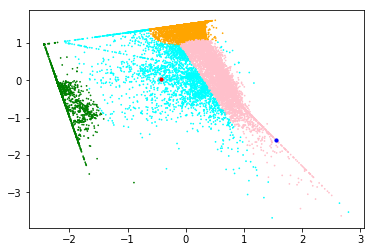

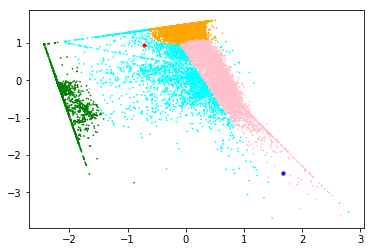

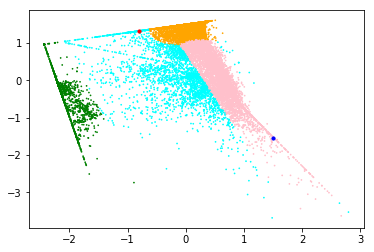

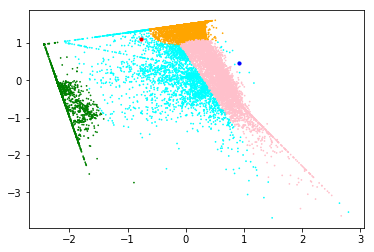

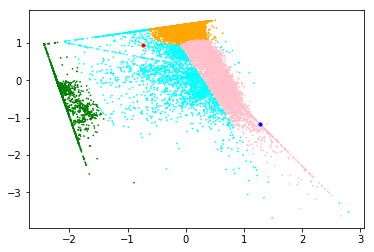

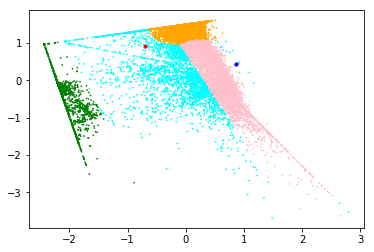

In [446]:
for i in range(6):
    colors = np.array(['aqua', 'green', 'orange', 'pink'])
    # add black color for outliers (if any)
    # colors = np.append(colors, ["black"])
    plt.scatter(X[:, 0], X[:, 1], s=0.5, color=colors[y_pred])
    plt.scatter(small_selected_data[i:i+1,0], small_selected_data[i:i+1,1], s=10, color='red')
    plt.scatter(large_selected_data[i:i+1,0], large_selected_data[i:i+1,1], s=10, color='blue')
    plt.show()

In [428]:
# Xdev_unscaled = X
Xdev_unscaled = scaler.inverse_transform(Xdev)
# centers = algo.cluster_centers_
centers = algo.means_
center_usage = centers.dot(output_weights) + output_bias

In [430]:
for i in range(center_usage.shape[0]):
    print('=' * 50)
    print('cluster {}'.format(i))
    cluster_X = Xdev[:n_examples][y_pred == i]
    cluster_true_usage = ydev[:n_examples][y_pred == i]
    mean_cluster_true_usage = np.mean(cluster_true_usage, axis=0)
    std_cluster_true_usage = np.std(cluster_true_usage, axis=0) #/ np.sqrt(cluster_true_usage.shape[0])

    mean_features = np.mean(cluster_X, axis=0)
    std_features = np.std(cluster_X, axis=0) / np.sqrt(cluster_X.shape[0])
    print(cluster_X.shape[0])
    print(cluster_X.shape[0] * 1.0 / n_examples)
    for k, name in enumerate(outputs_name):
        print('{0}: {1:.2f} +- {2:.2f}%'.format(
            name[3:8], mean_cluster_true_usage[k]*100, std_cluster_true_usage[k]*100))
    print('*' * 25)
    for fn in important_feature_names:
        i_feature = rev_feature_name_dict[fn]
        if (mean_features[i_feature] - std_features[i_feature] * 2) > 0.0:
            print('{0}: {1:.4f} +- {2:.4f}'.format(fn, mean_features[i_feature], std_features[i_feature]))

cluster 0
1464
0.10560484743562
excha: 71.20 +- 34.67%
share: 10.22 +- 21.75%
skype: 0.84 +- 5.95%
teams: 5.00 +- 15.50%
od4b_: 14.94 +- 24.24%
oneno: 2.39 +- 9.14%
word_: 28.43 +- 24.32%
excel: 28.60 +- 24.67%
power: 5.17 +- 11.16%
outlo: 52.36 +- 32.00%
eslt_: 74.37 +- 31.41%
offic: 59.34 +- 30.17%
*************************
PPDEnabledUsers: 0.0914 +- 0.0232
CountryCode=US: 0.1667 +- 0.0270
PaidProplusSeats: 0.0873 +- 0.0237
Languange=en: 0.1109 +- 0.0250
SfBSubscriptionsCount: 0.3855 +- 0.0154
TeamEnabledUsers: 0.0413 +- 0.0161
HasEXO: 0.3839 +- 0.0000
PaidKaizalaSeats: 0.0787 +- 0.0244
FirstPaidEXOStartDate: 0.3843 +- 0.0040
FirstPaidOD4BStartDate: 0.4596 +- 0.0018
TopParents_Industry=0: 0.1434 +- 0.0259
CountryCode=DE: 0.1567 +- 0.0338
FirstPaidProPlusStartDate: 0.6929 +- 0.0056
TeamsSubscriptionsCount: 0.3803 +- 0.0156
NonTrialSubscriptionsCount: 0.0619 +- 0.0267
PaidSPOSeats: 0.0724 +- 0.0239
ActivatedSubscriptionTotalCount: 0.0612 +- 0.0266
OD4BSubscriptionsCount: 0.1568 +- 0.02

In [327]:
for i in range(center_usage.shape[0]):
    print('=' * 50)
    print('cluster {}'.format(i))
    cluster_X = Xdev[:n_examples][y_pred == i]
    mean_features = np.mean(cluster_X, axis=0)
    print(cluster_X.shape[0])
    print(cluster_X.shape[0] * 1.0 / n_examples)
    for k, name in enumerate(outputs_name):
        print('{0}: {1:.2f}%'.format(name, np.maximum(center_usage[i,k]*100, 0.0)))
    print('*' * 25)
    for fn in industry_feature_names:
        i_feature = rev_feature_name_dict[fn]
        if mean_features[i_feature] > 0.02:
            print('{0}: {1:.4f}'.format(fn, mean_features[i_feature]))
    

cluster 0
2840
0.20486186251172184
AR_exchange_06: 62.45%
AR_sharepoint_06: 6.59%
AR_skype_06: 0.92%
AR_teams_06: 3.70%
AR_od4b_06: 9.97%
AR_onenote_06: 1.16%
AR_word_06: 19.47%
AR_excel_06: 21.27%
AR_powerpoint_06: 3.49%
AR_outlook_06: 37.23%
AR_eslt_06: 63.97%
AR_officeclient_06: 44.48%
*************************
TopParents_Industry=0: 0.0247
TopParents_Industry=Partner Professional Services: 0.0434
TopParents_Industry=Health Provider: 0.1894
TopParents_Industry=Nonprofit: 0.1112
TopParents_Industry=Media & Entertainment: 0.0363
TopParents_Industry=National Government: 0.0234
TopParents_Industry=Telecommunications: 0.0317
TopParents_Industry=Primary & Secondary Edu/K-12: 0.0736
TopParents_Industry=Higher Education: 0.0452
TopParents_Industry=Local Regional Government: 0.0323
TopParents_Industry=Pharmaceuticals: 0.0257
TopParents_Industry=Libraries & Museums: 0.0531
cluster 1
1843
0.13294380725672653
AR_exchange_06: 0.03%
AR_sharepoint_06: 1.47%
AR_skype_06: 1.99%
AR_teams_06: 0.45%
AR

In [214]:

for k, name in enumerate(outputs_name):
    print('=' * 50)
    print('workload {}'.format(name))
    for i in range(center_usage.shape[0]):
        print('{1}: {0:.2f}%'.format(np.maximum(center_usage[i,k]*100, 0.0), i))

workload AR_exchange_06
0: 71.68%
1: 0.31%
2: 75.43%
workload AR_sharepoint_06
0: 8.49%
1: 1.47%
2: 0.44%
workload AR_skype_06
0: 0.73%
1: 1.99%
2: 0.88%
workload AR_teams_06
0: 4.75%
1: 0.45%
2: 0.76%
workload AR_od4b_06
0: 11.66%
1: 7.30%
2: 2.29%
workload AR_onenote_06
0: 1.30%
1: 1.99%
2: 0.00%
workload AR_word_06
0: 20.98%
1: 27.53%
2: 0.61%
workload AR_excel_06
0: 22.60%
1: 31.44%
2: 1.11%
workload AR_powerpoint_06
0: 3.68%
1: 6.29%
2: 0.00%
workload AR_outlook_06
0: 42.36%
1: 20.18%
2: 24.31%
workload AR_eslt_06
0: 72.69%
1: 8.07%
2: 73.02%
workload AR_officeclient_06
0: 48.18%
1: 42.63%
2: 23.15%


In [183]:
center_usage = centers.dot(output_weights) + output_bias
for i in range(center_usage.shape[0]):
    print('=' * 50)
    print('center {}'.format(i))
    for k, name in enumerate(outputs_name):
        print('{0}: {1:.2f}%'.format(name, np.maximum(center_usage[i,k]*100, 0.0)))

center 0
AR_exchange_06: 80.96%
AR_sharepoint_06: 9.79%
AR_skype_06: 0.55%
AR_teams_06: 5.50%
AR_od4b_06: 12.67%
AR_onenote_06: 1.29%
AR_word_06: 21.04%
AR_excel_06: 22.42%
AR_powerpoint_06: 3.55%
AR_outlook_06: 46.12%
AR_eslt_06: 81.23%
AR_officeclient_06: 50.06%
center 1
AR_exchange_06: 0.00%
AR_sharepoint_06: 0.42%
AR_skype_06: 2.04%
AR_teams_06: 0.00%
AR_od4b_06: 6.21%
AR_onenote_06: 1.82%
AR_word_06: 25.70%
AR_excel_06: 29.56%
AR_powerpoint_06: 5.91%
AR_outlook_06: 17.62%
AR_eslt_06: 5.95%
AR_officeclient_06: 39.92%
center 2
AR_exchange_06: 75.23%
AR_sharepoint_06: 0.00%
AR_skype_06: 0.90%
AR_teams_06: 0.45%
AR_od4b_06: 1.59%
AR_onenote_06: 0.00%
AR_word_06: 0.00%
AR_excel_06: 0.00%
AR_powerpoint_06: 0.00%
AR_outlook_06: 22.87%
AR_eslt_06: 72.62%
AR_officeclient_06: 21.32%
center 3
AR_exchange_06: 76.71%
AR_sharepoint_06: 14.80%
AR_skype_06: 0.48%
AR_teams_06: 7.95%
AR_od4b_06: 18.59%
AR_onenote_06: 2.55%
AR_word_06: 34.32%
AR_excel_06: 36.48%
AR_powerpoint_06: 6.58%
AR_outlook_06

In [184]:
features = pd.read_csv

workload AR_exchange_06
0: 80.96%
1: 0.00%
2: 75.23%
3: 76.71%
4: 55.43%
5: 13.96%
6: 68.82%
workload AR_sharepoint_06
0: 9.79%
1: 0.42%
2: 0.00%
3: 14.80%
4: 0.00%
5: 4.07%
6: 6.16%
workload AR_skype_06
0: 0.55%
1: 2.04%
2: 0.90%
3: 0.48%
4: 1.24%
5: 1.71%
6: 0.83%
workload AR_teams_06
0: 5.50%
1: 0.00%
2: 0.45%
3: 7.95%
4: 0.00%
5: 1.90%
6: 3.55%
workload AR_od4b_06
0: 12.67%
1: 6.21%
2: 1.59%
3: 18.59%
4: 1.03%
5: 9.57%
6: 9.15%
workload AR_onenote_06
0: 1.29%
1: 1.82%
2: 0.00%
3: 2.55%
4: 0.00%
5: 2.14%
6: 0.87%
workload AR_word_06
0: 21.04%
1: 25.70%
2: 0.00%
3: 34.32%
4: 2.37%
5: 29.28%
6: 16.36%
workload AR_excel_06
0: 22.42%
1: 29.56%
2: 0.00%
3: 36.48%
4: 3.51%
5: 32.90%
6: 17.83%
workload AR_powerpoint_06
0: 3.55%
1: 5.91%
2: 0.00%
3: 6.58%
4: 0.00%
5: 6.46%
6: 2.69%
workload AR_outlook_06
0: 46.12%
1: 17.62%
2: 22.87%
3: 57.17%
4: 18.02%
5: 27.30%
6: 36.79%
workload AR_eslt_06
0: 81.23%
1: 5.95%
2: 72.62%
3: 79.36%
4: 54.90%
5: 20.89%
6: 69.35%
workload AR_officeclient_06
0:

In [234]:
dev_pred[0][i_workload]

0.028832432

In [235]:
last2nd_layer_output[0].dot(w) + b

0.028832432

In [275]:
ydev.shape

(13863, 12)

In [141]:
X = intermediate_output
# sc = StandardScaler()  
# X = sc.fit_transform(intermediate_output)

distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300, metric="precomputed")
tsne_results = tsne.fit_transform(distance_matrix)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 13863 samples in 0.182s...
[t-SNE] Computed neighbors for 13863 samples in 3.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13863
[t-SNE] Computed conditional probabilities for sample 2000 / 13863
[t-SNE] Computed conditional probabilities for sample 3000 / 13863
[t-SNE] Computed conditional probabilities for sample 4000 / 13863
[t-SNE] Computed conditional probabilities for sample 5000 / 13863
[t-SNE] Computed conditional probabilities for sample 6000 / 13863
[t-SNE] Computed conditional probabilities for sample 7000 / 13863
[t-SNE] Computed conditional probabilities for sample 8000 / 13863
[t-SNE] Computed conditional probabilities for sample 9000 / 13863
[t-SNE] Computed conditional probabilities for sample 10000 / 13863
[t-SNE] Computed conditional probabilities for sample 11000 / 13863
[t-SNE] Computed conditional probabilities for sample 12000 / 13863
[t-SNE] Computed conditional probabilities for sam

In [142]:
# data = pd.DataFrame(data=X, columns=[i for i in range(intermediate_output.shape[1])])
data = pd.read_csv('encoded_data_clip_fast/dev_set_raw_data.csv')
cols = data.columns.tolist()

/data/home/t-chepan/env/newlab/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [143]:
cols[-12:]

['AR_exchange_06',
 'AR_sharepoint_06',
 'AR_skype_06',
 'AR_teams_06',
 'AR_od4b_06',
 'AR_onenote_06',
 'AR_word_06',
 'AR_excel_06',
 'AR_powerpoint_06',
 'AR_outlook_06',
 'AR_eslt_06',
 'AR_officeclient_06']

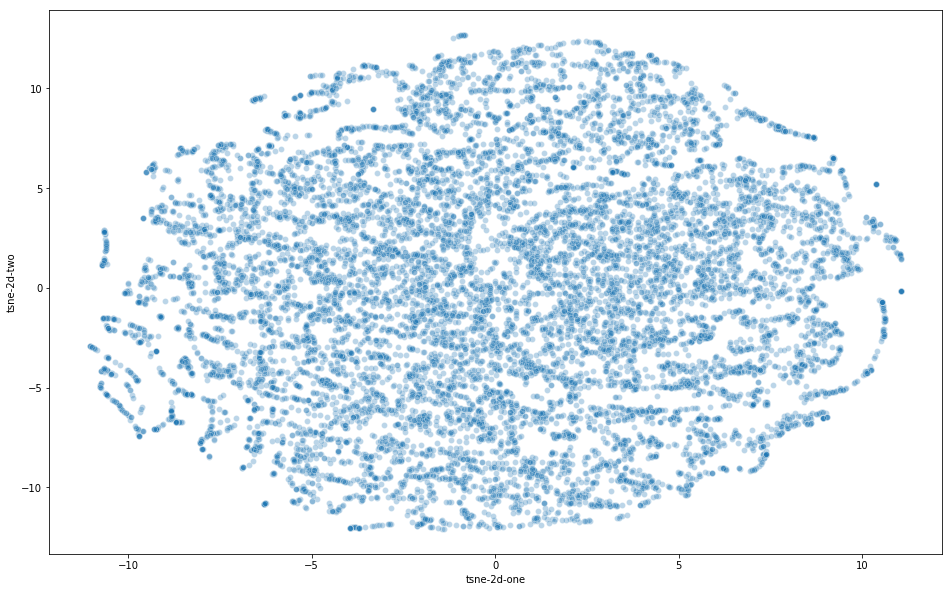

In [144]:
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    #hue="target",
    #palette=sns.color_palette("hls", 2),
    data=data,
    legend="full",
    alpha=0.3
)
# plt.savefig('plots/1per-cluster-tsne-profile.png')

In [145]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
data['pca-one'] = pca_result[:,0]
data['pca-two'] = pca_result[:,1] 
data['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.33797646 0.28361356 0.04788887]


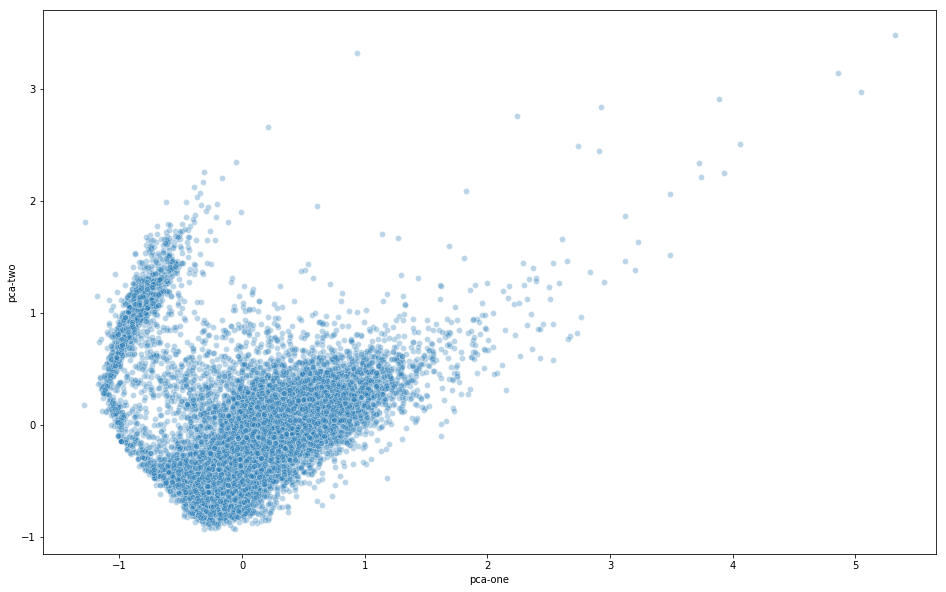

In [146]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
#     hue="target",
    palette=sns.color_palette("hls", 2),
    data=data,
    legend="full",
    alpha=0.3
)
# plt.savefig('plots/1per-cluster-pca-profile.png')

In [182]:
model_n = 0

In [160]:
model = loaded_model
last_hiden_layer_index = 4
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(index=last_hiden_layer_index).output)

intermediate_output = intermediate_layer_model.predict(Xdev)

In [162]:
intermediate_output.shape

(13863, 2)

In [178]:
output_weights = model.get_weights()[-2]

In [147]:
# model_n = best.index
# model_n = model_n[0]
model_n = 0

In [164]:
intermediate_output

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

## Simply use mean to predict the usage, what's the mse? 

In [104]:
ydev.shape

(13863, 12)

In [105]:
ytrain.shape

(1372529, 12)

In [106]:
mean_pred = np.mean(ytrain, axis=0)
mean_pred.shape

(12,)

In [114]:
mean_mse = np.mean(np.square(ydev - mean_pred))
mean_mse

0.8169947182001925

In [113]:
mean_mse_multi = np.mean(np.square(ydev - mean_pred), axis=0)
mean_mse_multi

array([2.34419446, 0.15412477, 0.00276937, 0.1736642 , 0.43636537,
       0.00648566, 0.26447185, 0.6825824 , 0.05135685, 1.65723474,
       2.25216427, 1.77852268])

In [115]:
mean_mse_workload_ = {}

for i, n in enumerate(outputs_name):
    
    mean_mse_workload_[n] = mean_mse_multi[i]
    
s = pd.Series(mean_mse_workload_).sort_values()

print(s)

AR_skype_06           0.002769
AR_onenote_06         0.006486
AR_powerpoint_06      0.051357
AR_sharepoint_06      0.154125
AR_teams_06           0.173664
AR_word_06            0.264472
AR_od4b_06            0.436365
AR_excel_06           0.682582
AR_outlook_06         1.657235
AR_officeclient_06    1.778523
AR_eslt_06            2.252164
AR_exchange_06        2.344194
dtype: float64


## Demo

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pickle as pkl
import joblib
import encoding_data

In [250]:
examples = pd.read_csv('data/dev_set_raw_data.csv')
#examples.head(10)

/data/home/t-chepan/env/newlab/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (142,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [251]:
examples.head()

,TenantId,CreatedDate,CreateDateOfFirstSubscription,CountryCode,AllupSeats,EXOSubscriptionsCount,OD4BSubscriptionsCount,SfBSubscriptionsCount,TeamsSubscriptionsCount,PaidCount,ProjectSubscriptionsCount,SPOSubscriptionsCount,ActivatedSubscriptionTotalCount,VisioSubscriptionsCount,TrialSubscriptionsCount,NonTrialSubscriptionsCount,Languange,DataCenterInstance,DataCenterModel,HasEXO,HasSPO,HasOD4B,HasSfB,HasYammer,HasTeams,HasTeamsFreemium,HasKaizala,HasProPlus,HasAADP,HasAIP,HasAATP,HasIntune,HasMCAS,HasWDATP,HasAudioConference,HasPhoneSystem,HasEdiscovery,HasCompliance,HasThreatIntelligence,HasCustomerLockbox,HasOATP,HasAADPP2,HasAIPP2,HasWindows,HasO365CAS,HasCASDiscovery,HasPAM,HasPowerBI,HasPowerBIPremium,HasPowerBIPro,HasVisio,HasProject,HasNonTrial,HasSubscription_AllCounted,WithoutTenantAdmin,OrgNameEnteredInCommerce,HasPartnerTenants,SignupLocationInfo_Country,SignupLocationInfo_CountryCode,SignupLocationInfo_Region,Subscriptions_HasPaidSeats,TopParents_AreaName,TopParents_BigAreaName,TopParents_CountryCode,TopParents_Industry,TopParents_RegionName,TopParents_SegmentGroup,TopParents_SubRegionName,TopParents_VerticalName,EXOEnabledUsers,SPOEnabledUsers,OD4BEnabledUsers,SFBEnabledUsers,TeamEnabledUsers,YammerEnabledUsers,PPDEnabledUsers,KaizalaEnabledUsers,AADPEnabledUsers,AIPEnabledUsers,AATPEnabledUsers,IntuneEnabledUsers,MCASEnabledUsers,WDATPEnabledUsers,AudioConferenceEnabledUsers,PhoneSystemEnabledUsers,EdiscoveryEnabledUsers,ComplianceEnabledUsers,ThreatIntelligenceEnabledUsers,CustomerLockboxEnabledUsers,OATPEnabledUsers,AADPP2EnabledUsers,AIPP2EnabledUsers,WindowsEnabledUsers,O365CASEnabledUsers,CASDiscoveryEnabledUsers,PAMEnabledUsers,O365EnabledUsers,EMSEnabledUsers,M365EnabledUsers,O365E5EnabledUsers,EMSE5EnabledUsers,M365E5EnabledUsers,TotalUsers,PaidEXOSeats,PaidSPOSeats,PaidOD4BSeats,PaidYammerSeats,PaidTeamsSeats,PaidSFBSeats,PaidKaizalaSeats,PaidProplusSeats,PaidAADPSeats,PaidAIPSeats,PaidAATPSeats,PaidIntuneSeats,PaidMCASSeats,PaidWDATPSeats,PaidAudioConferenceSeats,PaidPhoneSystemSeats,PaidOATPSeats,PaidAADPP2Seats,PaidAIPP2Seats,PaidWindowsSeats,PaidO365CASSeats,PaidCASDiscoverySeats,PaidPAMSeats,PaidPowerBISeats,PaidPowerBIPremiumSeats,PaidPowerBIProSeats,PaidEMSSeats,PaidM365Seats,PaidOfficeSeats,HasUsGovCloudOffer,FirstPaidEXOStartDate,FirstPaidSPOStartDate,FirstPaidOD4BStartDate,FirstPaidSfBStartDate,FirstPaidYammerStartDate,FirstPaidTeamsStartDate,FirstPaidProPlusStartDate,FirstPaidAADPStartDate,FirstPaidAIPStartDate,FirstPaidAATPStartDate,FirstPaidIntuneStartDate,FirstPaidMCASStartDate,FirstPaidO365E5SkuStartDate,FirstPaidM365E5SkuStartDate,FirstPaidEMSE5SkuStartDate,Has1YearFreeDomain,AU_exchange_04,AU_sharepoint_04,AU_skype_04,AU_teams_04,AU_od4b_04,AU_onenote_04,AU_word_04,AU_excel_04,AU_powerpoint_04,AU_outlook_04,AU_oatp_04,AU_odsp_04,AU_eslt_04,AU_officeclient_04,AU_exchange_05,AU_sharepoint_05,AU_skype_05,AU_teams_05,AU_od4b_05,AU_onenote_05,AU_word_05,AU_excel_05,AU_powerpoint_05,AU_outlook_05,AU_oatp_05,AU_odsp_05,AU_eslt_05,AU_officeclient_05,AU_exchange,AU_sharepoint,AU_skype,AU_teams,AU_od4b,AU_onenote,AU_word,AU_excel,AU_powerpoint,AU_outlook,AU_oatp,AU_odsp,AU_eslt,AU_officeclient,AR_exchange_04,AR_sharepoint_04,AR_skype_04,AR_teams_04,AR_od4b_04,AR_onenote_04,AR_word_04,AR_excel_04,AR_powerpoint_04,AR_outlook_04,AR_eslt_04,AR_officeclient_04,AR_exchange_05,AR_sharepoint_05,AR_skype_05,AR_teams_05,AR_od4b_05,AR_onenote_05,AR_word_05,AR_excel_05,AR_powerpoint_05,AR_outlook_05,AR_eslt_05,AR_officeclient_05,AR_exchange_06,AR_sharepoint_06,AR_skype_06,AR_teams_06,AR_od4b_06,AR_onenote_06,AR_word_06,AR_excel_06,AR_powerpoint_06,AR_outlook_06,AR_eslt_06,AR_officeclient_06
0,8A06EA26-549C-4DDF-AF9E-DE3D492F9F43,11/28/2011 5:30:16 PM,8/9/2017 12:00:00 AM,US,18,2,2,1,1,18,1,2,4,0,0,4,en,Global|GoLocal,PublicCloud|GoLocal,True,True,True,True,True,True,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [252]:
examples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13863 entries, 0 to 13862
Columns: 227 entries, TenantId to AR_officeclient_06
dtypes: bool(40), float64(91), int64(64), object(32)
memory usage: 20.3+ MB


In [255]:
example_df = examples.iloc[1:2, :].copy()

In [ ]:
df_X, df_y = encoding_data.separate_input_output_cols(example_df, predict_ahead=0, previous_usage=0)

In [257]:
X_scal, _ = encoding_data.encode_dev_test_inputs(df_X, dv, scaler)

Starting to encode dev or test inputs...



KeyboardInterrupt



In [247]:
324 + 62 + 55 + 40 + 8

0.24.2


489

In [253]:
dv_file = '/data/home/t-chepan/projects/MS-intern-project/data/vectorizer.pkl' 
scaler_file = '/data/home/t-chepan/projects/MS-intern-project/data/scaler.pkl'
# default_example = {}
dv = joblib.load(dv_file)
scaler = joblib.load(scaler_file)

def encode_input(df, dv, scaler):
    df_X, df_y = encoding_data.separate_input_output_cols(df, predict_ahead=0, previous_usage=0)
    X_scal, _ = encoding_data.encode_dev_test_inputs(df_X, dv, scaler)
    print(X_scal.shape)
    return X_scal, df_y

def decode_output(output, names):
    usage_pattern = {}
    for i, name in enumerate(names):
        usage_pattern[name] = output[i]
    return usage_pattern

def predict_usage_pattern(model, example_df, dv, workload_names, scaler):
    example_input, df_y = encode_input(example_df, dv, scaler)
    output = model.predict(example_input)
    usage_pattern = decode_output(output[0], workload_names)
    return usage_pattern, df_y


# def display(usage_pattern):
#     for k, v in usage_pattern.items():
#         print('workload: {}, usage: {}'.format(k, v))
        

In [9]:
example_df = examples.iloc[1:2, :].copy()

usage_pattern, df_y = predict_usage_pattern(loaded_model, example_df, dv, outputs_name, scaler)
usage_pattern

# display(usage_pattern)
# lists = sorted(usage_pattern.items()) # sorted by key, return a list of tuples

# x, y = zip(*lists) # unpack a list of pairs into two tuples

# plt.bar(x, y)
# plt.xticks(rotation=90)
# plt.show()

NameError: name 'examples' is not defined

In [131]:
set(df_train['TopParents_Industry'])

{'0',
 'Automotive',
 'Banking & Capital Markets',
 'Chemicals & Agrochemicals',
 'Consumer Goods',
 'Defense & Intelligence',
 'Discrete Manufacturing',
 'Energy',
 'Forestry & Fishing',
 'Gaming',
 'Health Payor',
 'Health Provider',
 'Higher Education',
 'Insurance',
 'Libraries & Museums',
 'Local Regional Government',
 'Media & Entertainment',
 'National Government',
 'Nonprofit',
 'Other - Unsegmented',
 'Partner Professional Services',
 'Pharmaceuticals',
 'Primary & Secondary Edu/K-12',
 'Professional Services',
 'Retailers',
 'Smart Spaces',
 'Telecommunications',
 'Travel & Transportation'}

outputs shape is (1, 12)
inputs shape is (1, 191)
Starting to encode dev or test inputs...
{'AR_outlook_06': 0.6078834, 'AR_powerpoint_06': -0.030275349, 'AR_word_06': -0.0019260347, 'AR_exchange_06': 0.72613996, 'AR_eslt_06': 0.9676844, 'AR_sharepoint_06': 1.2546641, 'AR_teams_06': 0.02764214, 'AR_officeclient_06': 0.6788437, 'AR_skype_06': -0.021691568, 'AR_excel_06': -0.074682474, 'AR_od4b_06': 0.2589141, 'AR_onenote_06': -0.009499604}


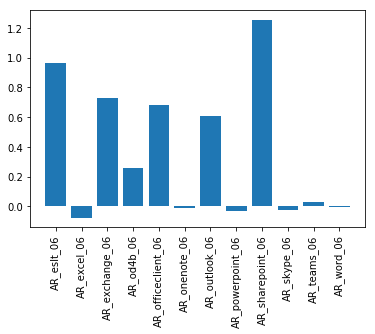

In [139]:
example_df['AllupSeats'] = 200
example_df['CountryCode'] = 'US'
# example_df['TopParents_Industry'] = '0'

example_df['TopParents_Industry'] = 'Telecommunications'


usage_pattern, df_y = predict_usage_pattern(loaded_model, example_df, dv, outputs_name, scaler)
print(usage_pattern)

lists = sorted(usage_pattern.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

outputs shape is (1, 12)
inputs shape is (1, 191)
Starting to encode dev or test inputs...
{'AR_outlook_06': 0.32676965, 'AR_powerpoint_06': 0.03203911, 'AR_word_06': 0.14829825, 'AR_exchange_06': 0.84699994, 'AR_eslt_06': 0.83992803, 'AR_sharepoint_06': 0.134666, 'AR_teams_06': 0.037909556, 'AR_officeclient_06': 0.3452013, 'AR_skype_06': 0.020363506, 'AR_excel_06': 0.16442612, 'AR_od4b_06': 0.07195382, 'AR_onenote_06': 0.009282259}


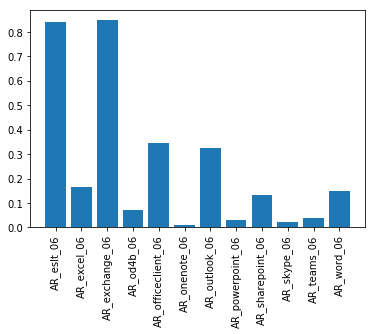

In [141]:
example_df['AllupSeats'] = 200
example_df['PaidPhoneSystemSeats'] = 200
example_df['CountryCode'] = 'LU'
example_df['TopParents_Industry'] = 'Health Provider'
# example_df['TopParents_Industry'] = 'Telecommunications'


usage_pattern, df_y = predict_usage_pattern(loaded_model, example_df, dv, outputs_name, scaler)
print(usage_pattern)

lists = sorted(usage_pattern.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

outputs shape is (1, 12)
inputs shape is (1, 191)
Starting to encode dev or test inputs...
{'AR_outlook_06': 0.5584716, 'AR_powerpoint_06': 0.036912292, 'AR_word_06': 0.21682893, 'AR_exchange_06': 0.7675637, 'AR_eslt_06': 0.87325585, 'AR_sharepoint_06': 1.0127981, 'AR_teams_06': 0.035058863, 'AR_officeclient_06': 0.63702923, 'AR_skype_06': 0.026213381, 'AR_excel_06': 0.20309034, 'AR_od4b_06': 0.13962746, 'AR_onenote_06': 0.00789956}


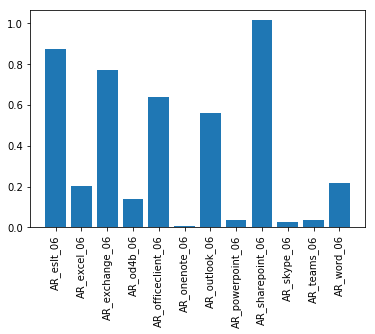

In [134]:
example_df['AllupSeats'] = 20
example_df['CountryCode'] = 'US'
example_df['TopParents_Industry'] = 'Banking & Capital Markets'

usage_pattern, df_y = predict_usage_pattern(loaded_model, example_df, dv, outputs_name, scaler)
print(usage_pattern)

lists = sorted(usage_pattern.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

In [95]:
## original default example
example_df = df_train.iloc[2:3, :].copy()
example_df

,TenantId,CreatedDate,CreateDateOfFirstSubscription,CountryCode,AllupSeats,EXOSubscriptionsCount,OD4BSubscriptionsCount,SfBSubscriptionsCount,TeamsSubscriptionsCount,PaidCount,ProjectSubscriptionsCount,SPOSubscriptionsCount,ActivatedSubscriptionTotalCount,VisioSubscriptionsCount,TrialSubscriptionsCount,NonTrialSubscriptionsCount,Languange,DataCenterInstance,DataCenterModel,HasEXO,HasSPO,HasOD4B,HasSfB,HasYammer,HasTeams,HasTeamsFreemium,HasKaizala,HasProPlus,HasAADP,HasAIP,HasAATP,HasIntune,HasMCAS,HasWDATP,HasAudioConference,HasPhoneSystem,HasEdiscovery,HasCompliance,HasThreatIntelligence,HasCustomerLockbox,HasOATP,HasAADPP2,HasAIPP2,HasWindows,HasO365CAS,HasCASDiscovery,HasPAM,HasPowerBI,HasPowerBIPremium,HasPowerBIPro,HasVisio,HasProject,HasNonTrial,HasSubscription_AllCounted,WithoutTenantAdmin,OrgNameEnteredInCommerce,HasPartnerTenants,SignupLocationInfo_Country,SignupLocationInfo_CountryCode,SignupLocationInfo_Region,Subscriptions_HasPaidSeats,TopParents_AreaName,TopParents_BigAreaName,TopParents_CountryCode,TopParents_Industry,TopParents_RegionName,TopParents_SegmentGroup,TopParents_SubRegionName,TopParents_VerticalName,EXOEnabledUsers,SPOEnabledUsers,OD4BEnabledUsers,SFBEnabledUsers,TeamEnabledUsers,YammerEnabledUsers,PPDEnabledUsers,KaizalaEnabledUsers,AADPEnabledUsers,AIPEnabledUsers,AATPEnabledUsers,IntuneEnabledUsers,MCASEnabledUsers,WDATPEnabledUsers,AudioConferenceEnabledUsers,PhoneSystemEnabledUsers,EdiscoveryEnabledUsers,ComplianceEnabledUsers,ThreatIntelligenceEnabledUsers,CustomerLockboxEnabledUsers,OATPEnabledUsers,AADPP2EnabledUsers,AIPP2EnabledUsers,WindowsEnabledUsers,O365CASEnabledUsers,CASDiscoveryEnabledUsers,PAMEnabledUsers,O365EnabledUsers,EMSEnabledUsers,M365EnabledUsers,O365E5EnabledUsers,EMSE5EnabledUsers,M365E5EnabledUsers,TotalUsers,PaidEXOSeats,PaidSPOSeats,PaidOD4BSeats,PaidYammerSeats,PaidTeamsSeats,PaidSFBSeats,PaidKaizalaSeats,PaidProplusSeats,PaidAADPSeats,PaidAIPSeats,PaidAATPSeats,PaidIntuneSeats,PaidMCASSeats,PaidWDATPSeats,PaidAudioConferenceSeats,PaidPhoneSystemSeats,PaidOATPSeats,PaidAADPP2Seats,PaidAIPP2Seats,PaidWindowsSeats,PaidO365CASSeats,PaidCASDiscoverySeats,PaidPAMSeats,PaidPowerBISeats,PaidPowerBIPremiumSeats,PaidPowerBIProSeats,PaidEMSSeats,PaidM365Seats,PaidOfficeSeats,HasUsGovCloudOffer,FirstPaidEXOStartDate,FirstPaidSPOStartDate,FirstPaidOD4BStartDate,FirstPaidSfBStartDate,FirstPaidYammerStartDate,FirstPaidTeamsStartDate,FirstPaidProPlusStartDate,FirstPaidAADPStartDate,FirstPaidAIPStartDate,FirstPaidAATPStartDate,FirstPaidIntuneStartDate,FirstPaidMCASStartDate,FirstPaidO365E5SkuStartDate,FirstPaidM365E5SkuStartDate,FirstPaidEMSE5SkuStartDate,Has1YearFreeDomain,AU_exchange_04,AU_sharepoint_04,AU_skype_04,AU_teams_04,AU_od4b_04,AU_onenote_04,AU_word_04,AU_excel_04,AU_powerpoint_04,AU_outlook_04,AU_oatp_04,AU_odsp_04,AU_eslt_04,AU_officeclient_04,AU_exchange_05,AU_sharepoint_05,AU_skype_05,AU_teams_05,AU_od4b_05,AU_onenote_05,AU_word_05,AU_excel_05,AU_powerpoint_05,AU_outlook_05,AU_oatp_05,AU_odsp_05,AU_eslt_05,AU_officeclient_05,AU_exchange,AU_sharepoint,AU_skype,AU_teams,AU_od4b,AU_onenote,AU_word,AU_excel,AU_powerpoint,AU_outlook,AU_oatp,AU_odsp,AU_eslt,AU_officeclient,AR_exchange_04,AR_sharepoint_04,AR_skype_04,AR_teams_04,AR_od4b_04,AR_onenote_04,AR_word_04,AR_excel_04,AR_powerpoint_04,AR_outlook_04,AR_eslt_04,AR_officeclient_04,AR_exchange_05,AR_sharepoint_05,AR_skype_05,AR_teams_05,AR_od4b_05,AR_onenote_05,AR_word_05,AR_excel_05,AR_powerpoint_05,AR_outlook_05,AR_eslt_05,AR_officeclient_05,AR_exchange_06,AR_sharepoint_06,AR_skype_06,AR_teams_06,AR_od4b_06,AR_onenote_06,AR_word_06,AR_excel_06,AR_powerpoint_06,AR_outlook_06,AR_eslt_06,AR_officeclient_06
4,4022B92B-EA9F-497B-985D-D335EB3CE735,10/31/2013 11:30:36 AM,10/31/2013 12:00:00 AM,US,12,1,0,0,0,12,0,0,2,0,0,2,en,Global|GoLocal,PublicCloud|GoLocal,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [96]:
example_df['CountryCode'] = 'UK'

In [212]:
def separate_input_output_cols(df):
    cols_name = pd.Series(data=df.columns)

    ar_04_beg_col_index = cols_name[cols_name == 'AR_exchange_04'].index[0]
    ar_06_beg_col_index = cols_name[cols_name == 'AR_exchange_06'].index[0]
    ar_06_end_col_index = cols_name[cols_name == 'AR_officeclient_06'].index[0]

    wl_AR_cols = cols_name[ar_04_beg_col_index:ar_06_end_col_index+1].tolist()

    output_cols = cols_name[ar_06_beg_col_index:ar_06_end_col_index+1].tolist()

    y = df.loc[:, output_cols]

    X = df.drop(columns=wl_AR_cols) # use profile only

    return X, y

In [228]:
dv_file = '/data/home/t-chepan/projects/MS-intern-project/results/vectorizer.pkl' 
scaler_file = '/data/home/t-chepan/projects/MS-intern-project/results/scaler.pkl'
default_example = {}
dv = joblib.load(dv_file)
scaler = joblib.load(scaler_file)

def encode_input(df, dv, scaler):
    df_X, df_y = separate_input_output_cols(df)
    X_arr = encoding_data.encode_dev_test_inputs(
        df_X, dv, 'demo')
    return scaler.transform(X_arr), df_y

def decode_output(output, names):
    usage_pattern = {}
    for i, name in enumerate(names):
        usage_pattern[name] = output[i]
    return usage_pattern

def predict_usage_pattern(model, example_df, dv, workload_names, scaler):
    example_input, df_y = encode_input(example_df, dv, scaler)
    output = model.predict(example_input)
    usage_pattern = decode_output(output[0], workload_names)
    return usage_pattern, df_y


def display(usage_pattern):
    for k, v in usage_pattern.items():
        print('workload: {}, usage: {}'.format(k, v))
        

example_df = df_test.iloc[4:5, :]

usage_pattern, df_y = predict_usage_pattern(loaded_model, example_df, dv, outputs_name, scaler)

display(usage_pattern)

Starting to encode dev or test inputs:
workload: AR_outlook_06, usage: 1.2955379486083984
workload: AR_od4b_06, usage: 0.31473976373672485
workload: AR_teams_06, usage: -0.006440533325076103
workload: AR_sharepoint_06, usage: 0.7883325219154358
workload: AR_skype_06, usage: -0.009027969092130661
workload: AR_eslt_06, usage: 1.557942509651184
workload: AR_exchange_06, usage: 1.4134788513183594
workload: AR_powerpoint_06, usage: 0.03916526585817337
workload: AR_officeclient_06, usage: 1.376962661743164
workload: AR_onenote_06, usage: 0.012934449128806591
workload: AR_word_06, usage: 0.3316196799278259
workload: AR_excel_06, usage: 0.29720357060432434


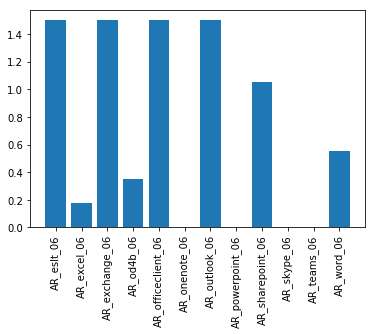

In [255]:
y = list(df_y.values[0])

cols = df_y.columns.to_list()


acr_usage_pattern = {}
for i in range(len(y)):
    acr_usage_pattern[cols[i]] = y[i]

lists = sorted(acr_usage_pattern.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()    

In [259]:
# example_df['AllupSeats'] = 3

# usage_pattern = predict_usage_pattern(
#     loaded_model, example_df, dv, outputs_name, scaler)
# display(usage_pattern)

# lists = sorted(usage_pattern.items()) # sorted by key, return a list of tuples

# x, y = zip(*lists) # unpack a list of pairs into two tuples

# plt.bar(x, y)
# plt.xticks(rotation=90)
# plt.show()


In [223]:
example_df.columns

Index(['TenantId', 'CreatedDate', 'CreateDateOfFirstSubscription',
       'CountryCode', 'AllupSeats', 'EXOSubscriptionsCount',
       'OD4BSubscriptionsCount', 'SfBSubscriptionsCount',
       'TeamsSubscriptionsCount', 'PaidCount',
       ...
       'AR_skype_06', 'AR_teams_06', 'AR_od4b_06', 'AR_onenote_06',
       'AR_word_06', 'AR_excel_06', 'AR_powerpoint_06', 'AR_outlook_06',
       'AR_eslt_06', 'AR_officeclient_06'],
      dtype='object', length=227)

['AR_exchange_06',
 'AR_sharepoint_06',
 'AR_skype_06',
 'AR_teams_06',
 'AR_od4b_06',
 'AR_onenote_06',
 'AR_word_06',
 'AR_excel_06',
 'AR_powerpoint_06',
 'AR_outlook_06',
 'AR_eslt_06',
 'AR_officeclient_06']